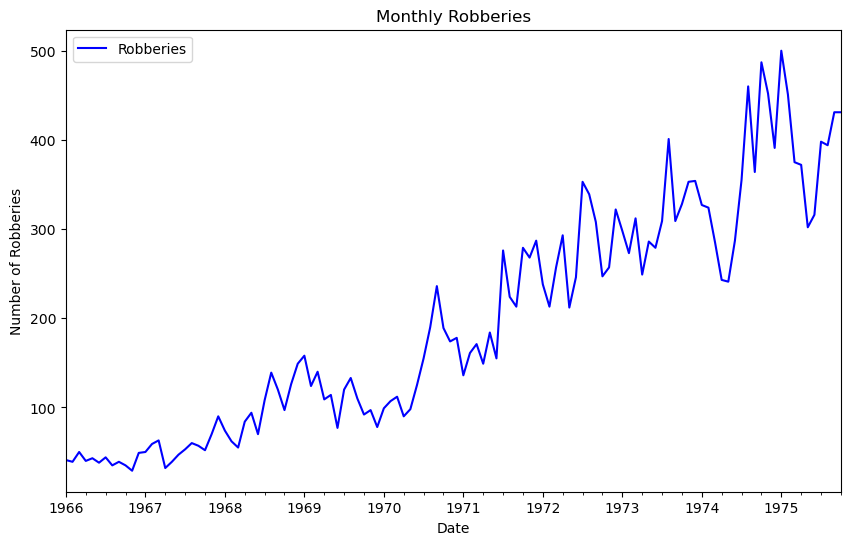

<Figure size 1000x800 with 0 Axes>

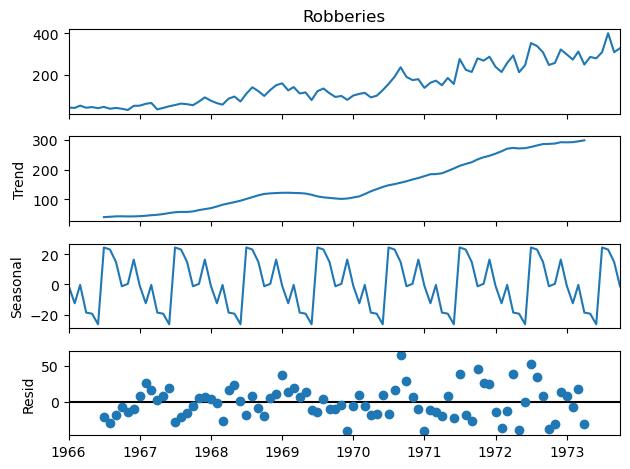

Random Forest RMSE: 86.17481368495302
ETS Model RMSE: 60.62810119451529
Linear Regression RMSE: 53.87079907845938

Comparison of Approaches:
Random Forest RMSE: 86.17481368495302
ETS Model RMSE: 60.62810119451529
Linear Regression RMSE: 53.87079907845938


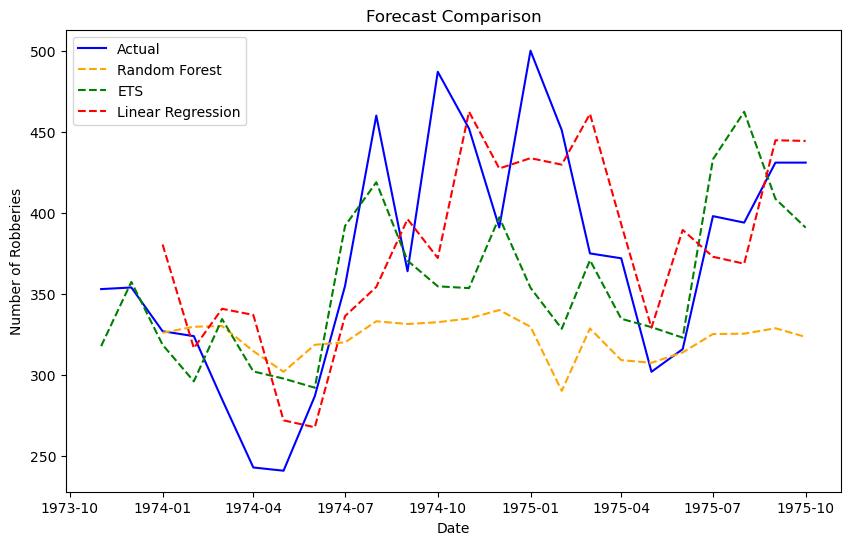

In [1]:
#Project by Akhmatukaev Dokka

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose

# We will use the data set of monthly robberies from 1966 to 1975. 
# This dataset has only two columns. Each month has assigned number of robberies
# The data set was taken from github.com https://github.com/jbrownlee/Datasets/blob/master/monthly-robberies.csv



# Loading the dataset
data = pd.read_csv('monthly-robberies.csv')
data['Month'] = pd.to_datetime(data['Month'], format='%Y-%m')  # Parse 'Month' column so it can be seen as datetime object
data.set_index('Month', inplace=True)  # Set the 'Month' column as the index
data = data.asfreq('MS') # Set the frequency to monthly

# Select the target column ('Robberies') for analysis
time_series = data['Robberies']

# Visualizing the time series
plt.figure(figsize=(10, 6))
# Labeling the graph
time_series.plot(title="Monthly Robberies", label="Robberies", color='blue')
plt.xlabel("Date")
plt.ylabel("Number of Robberies")
plt.legend()
plt.show()

# Splitting the data into training and testing sets
train, test = train_test_split(time_series, test_size=0.2, shuffle=False)

# Decomposing the time series
# Performing seasonal decomposition
decomposition = seasonal_decompose(train, model='additive', period=12)

# Plot the decomposition results
plt.figure(figsize=(10, 8))
decomposition.plot()
plt.show()

# Forecast using Random Forest
# Use a function to create lagged features (12 months each year) for time series forecasting
def create_lag_features(series, lags=12):
    # Create a DataFrame with lagged values (12) as features
    df = pd.DataFrame({f"lag_{i}": series.shift(i) for i in range(1, lags + 1)})
    df['target'] = series
    return df

# Generating lagged features for Random Forest
rf_data = create_lag_features(time_series)
rf_data.dropna(inplace=True)  # This drops rows with NaN values due to lagging
X = rf_data.drop(columns=['target']) #Lagged values are predictors
y = rf_data['target'] #The target is the current time step

# Split the lagged data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Fit a Random Forest Regressor to the training data
rand_forest = RandomForestRegressor(n_estimators=100, random_state=42)
rand_forest.fit(X_train, y_train)

# Make predictions using the test set and calculate RMSE
rf_predictions = rand_forest.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
print(f"Random Forest RMSE: {rf_rmse}")

# Forecast using ETS model
# Apply Exponential Smoothing with additive trend and multiplicative seasonality
ets_model = ExponentialSmoothing(train, seasonal='multiplicative', trend='additive', seasonal_periods=12)
ets_fit = ets_model.fit()

# Forecast on the test set and calculate RMSE
ets_predictions = ets_fit.forecast(len(test))
ets_rmse = np.sqrt(mean_squared_error(test, ets_predictions))
print(f"ETS Model RMSE: {ets_rmse}")

# For point 6 we'll use Linear Regression to make a Forecast
# Prepare features for Linear Regression
lagged_data = create_lag_features(time_series)
lagged_data.dropna(inplace=True)
X = lagged_data.drop(columns=['target'])
y = lagged_data['target']

# Split the lagged data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Fit a Linear Regression model to the training data
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Make predictions using the test set and calculate RMSE
lr_predictions = lin_reg.predict(X_test)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_predictions))
print(f"Linear Regression RMSE: {lr_rmse}")

# Comparing the approaches 
# Print the RMSE values for all models to compare performance
print("\nComparison of Approaches:")
print(f"Random Forest RMSE: {rf_rmse}")
print(f"ETS Model RMSE: {ets_rmse}")
print(f"Linear Regression RMSE: {lr_rmse}")

# Now to see how well each of them will make a prediction for the last rows (period from 1973 to 1975)
# Ensure the predictions align with the test dataset
# Align indices between test and predictions
test_rf = test.iloc[-len(rf_predictions):]  # Select the last len(rf_predictions) rows from the test set
test_ets = test.iloc[-len(ets_predictions):]  # Align ETS predictions
test_lr = test.iloc[-len(lr_predictions):]  # Align Linear Regression predictions

# Now to plot the actual values and the forecasts
plt.figure(figsize=(10, 6))
plt.plot(test.index, test.values, label="Actual", color="blue")
plt.plot(test_rf.index, rf_predictions, label="Random Forest", linestyle="--", color="orange")
plt.plot(test_ets.index, ets_predictions, label="ETS", linestyle="--", color="green")
plt.plot(test_lr.index, lr_predictions, label="Linear Regression", linestyle="--", color="red")
plt.title("Forecast Comparison")
plt.xlabel("Date")
plt.ylabel("Number of Robberies")
plt.legend()
plt.show()

#Looking at RMSE and the graph we will see which model is the best.
#Linear Regression will have the smallest RMSE and its graph will be the closest to the actual graph
#Random Forest will be the worst one. With highest RMSE and the least similar looking graph
